## Exploring the dataset

In [1]:
#1. train_labels.csv 파일을 불러오고 head만 출력시키기.
import pandas as pd

path2csv="./data/train_labels.csv"
labels = pd.read_csv(path2csv)
labels.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [2]:
#2. normal과 malignant 의 숫자를 세어보자.
print(labels['label'].value_counts)

<bound method IndexOpsMixin.value_counts of 0         0
1         1
2         0
3         0
4         0
         ..
220020    0
220021    1
220022    0
220023    0
220024    1
Name: label, Length: 220025, dtype: int64>


<AxesSubplot:>

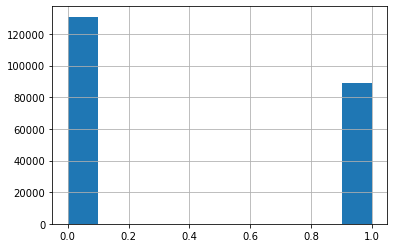

In [3]:
#3. labels를 히스토그램으로 나타내어보자.
%matplotlib inline
labels['label'].hist()

In [4]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [5]:
# get ids for malignant images
malignantIds = labels.loc[labels['label']==1]['id'].values

In [6]:
malignantIds

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f', ...,
       '309210db7f424edbc22b2d13bf2fa27518b18f5c',
       'd4b854fe38b07fe2831ad73892b3cec877689576',
       'a81f84895ddcd522302ddf34be02eb1b3e5af1cb'], dtype=object)

In [7]:
malignantIds[:3]

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f'], dtype=object)

In [8]:
# data is stored here
path2train = './data/train/'

In [9]:
# 그레이 색으로 보고 싶으면 false
color=False

In [10]:
# figure sizes를 맞춘다.
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3,3

<Figure size 720x720 with 0 Axes>

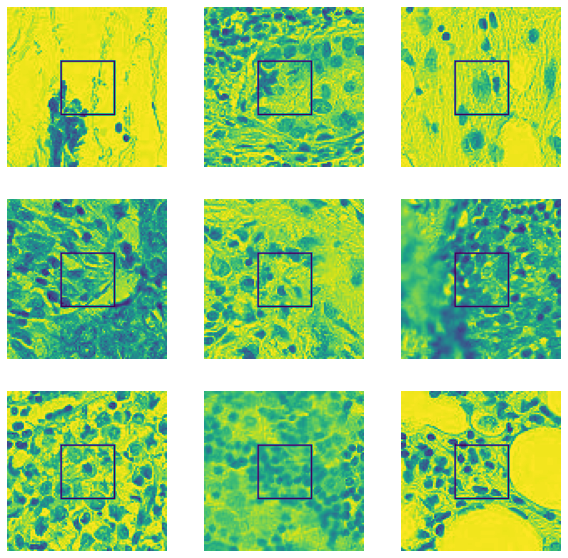

In [11]:
# 이미지를 보이자.
for i, id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_+'.tif')
    
    # 이미지 불러오기
    img = Image.open(full_filenames)
    
    # 32 * 32 직사각형 그리기
    draw = ImageDraw.Draw(img)
    # (32,32),(64,64) 점 찍고 사각형을 그린다.
    draw.rectangle(((32,32),(64,64)), outline="green")
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0])
    plt.axis('off')
    
# => 위 직사각형 안에 악성이 포함되어 있다는 것을 알려준다.

In [12]:
#5. 이미지 형태와 픽셀 값의 작은 크기와 큰 크기를 나타내시오.
print("Image shape:", np.array(img).shape)
print("pixel values rangefrom %s to %s" %(np.min(img),np.max(img)))

Image shape: (96, 96, 3)
pixel values rangefrom 0 to 255


## Creating a custom dataset

먼저 transformation function을 정의하고 Dataset class를 load 할거임

In [13]:
#1. 우리 데이터에서 Pytorch custom dataset 을 만든다.

# First, required pacakges를 load 한다.
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

In [14]:
# 아래는 torch의 랜덤 시드 발생
torch.manual_seed(0)

In [15]:
# 클래스 정의
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # 이미지의 경로
        path2data=os.path.join(data_dir,data_type)

        # 이미지의 list
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [16]:
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [17]:
#2. 간단한 변환을 PIL이미지에서 Pytorch Tensor로 한다.

import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [18]:
#3.train folder를 만든다.

data_dir="./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer,"train")
print(len(histo_dataset))

220025


In [19]:
#4.image를 custom dataset을 사용해 로드하시오

img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [20]:
histo_dataset[8]

(tensor([[[0.2667, 0.3765, 0.4824,  ..., 0.8902, 0.8824, 0.8157],
          [0.3961, 0.3020, 0.3843,  ..., 0.9882, 0.9882, 0.9098],
          [0.3686, 0.5137, 0.5333,  ..., 0.8275, 0.8275, 0.9804],
          ...,
          [0.6275, 0.6353, 0.6392,  ..., 0.8941, 0.9020, 0.9020],
          [0.6510, 0.4235, 0.9961,  ..., 0.9020, 0.9020, 0.9059],
          [0.9255, 0.8392, 0.6078,  ..., 0.9020, 0.9059, 0.9059]],
 
         [[0.1098, 0.2000, 0.2863,  ..., 0.4392, 0.4471, 0.3882],
          [0.2157, 0.1137, 0.1765,  ..., 0.5373, 0.5451, 0.4784],
          [0.1725, 0.3059, 0.3137,  ..., 0.3804, 0.3882, 0.5529],
          ...,
          [0.3608, 0.3725, 0.3765,  ..., 0.8667, 0.8627, 0.8627],
          [0.3686, 0.1451, 0.7216,  ..., 0.8627, 0.8627, 0.8588],
          [0.6314, 0.5608, 0.3294,  ..., 0.8627, 0.8627, 0.8588]],
 
         [[0.5569, 0.6039, 0.6353,  ..., 0.8039, 0.8078, 0.7451],
          [0.6392, 0.5020, 0.5216,  ..., 0.8941, 0.8980, 0.8196],
          [0.5451, 0.6667, 0.6549,  ...,

## Splitting the dataset

- Split의 단점이 있다.

바로 data를 train,val로 나누게 되면 나눠진 데이터는 더이상 다른 데이터로 갈 수가 없다. train -> val 또는 val -> train으로 바꿀 수 없다는 이야기이다. 이를 해결하기 위해 KFold()를 쓰면 된다.

- 위 과정에서는 KFold()가 없는데 그럼 어떻게 하면 되는가 ?

뒤에서 batch_size랑 shuffle을 해주기 때문에 따로 어떤 액션을 취할 필요가 없다.

In [21]:
# trian : val = 8 : 2
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [22]:
# 모양 확인
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [23]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


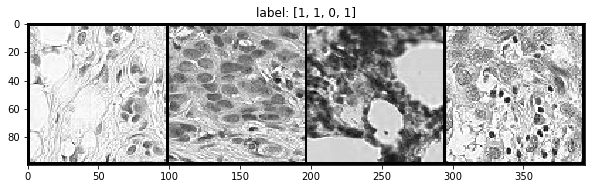

In [24]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)


def show(img,y, color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0] # gray 컬러로 출력하겠다는 의미
        # interpolation은 영상 확대나 축소에 많이 사용하는데
        # 위는 영상을 줄이기 위해 그 주위의 픽셀을 쓰겠다는 의미이다.
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

grid_size=4
# 0 <= x < len(train_ds) 범위의 grid_size만큼 수를 반환하겠다.
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds] # img
y_grid_train=[train_ds[i][1] for i in rnd_inds] # labels

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10, 5)
show(x_grid_train,y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


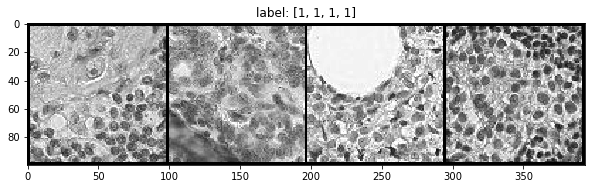

In [25]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

## Transforming the data

In [26]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])     

In [27]:
# val은 증가시킬 필요가 없어서 이미지만 ToTensor() 변환을 한다.
val_transformer = transforms.Compose([transforms.ToTensor()]) 

In [28]:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

## Creating Dataloaders

- Dataloader를 쓰는 이유

데이터로더를 안쓰면 데이터셋을 반복해서 적고 데이터 배치를 추출해야한다. 만약 데이터로더를 쓰면 얘가 알아서 다 해줌

In [29]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)  

176020의 데이터의 배치 사이즈를 32로 하면 5500번 정도 돌 수 있다. 그 후 데이터를 다시 shuffle 하고 32씩 잘라서 또 돌리는 것이다.

In [30]:
# extract a batch from trainin data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 96, 96])
torch.Size([32])


In [31]:
# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


## Building Classification Model

모델을 학습 시키기 전에 먼저 라벨 값을 전부 0 또는 전부 1 또는 두 개를 섞어서 나온 값으로 두고 비교를 한다. dumb baseline

In [33]:
# get labels for validation dataset
y_val=[y for _,y in val_ds]    

def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

# accuracy all zero predictions
# zeros_like : 이미 있는 array와 동일한 모양의 데이터 형태를
# 유지한 상태에서 각 0을 반환한다.
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))

# accuracy all ones predictions
acc_all_ones=accuracy(y_val,np.ones_like(y_val))

# accuracy random predictions
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)
print("accuracy all zero prediction: %.2f" %acc_all_zeros)
print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy random prediction: 0.50
accuracy all zero prediction: 0.59
accuracy all one prediction: 0.41


In [34]:
import numpy as np
# 2 미만에 값 5개 랜덤으로 뽑아내기
a = np.random.randint(2, size=5)
print(a)

[1 0 1 1 0]


In [35]:
import torch.nn as nn
import numpy as np

def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation # 팽창
    # 필터가 추출해내는 input의 간격이 멀어지는 것이다.

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(48,48,conv1)
print(h,w)

23 23


In [36]:
import torch.nn as nn
import torch.nn.functional as F
#메소드 오버라이딩
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # flatten을 안해주면 영상 자체를 출력한다.
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # 얘네 값은 전부 음수


- kernel size에 홀수를 주로 쓰는 이유?

커널 사이즈는 보통 3,5 등을 이용하여 추출한다.
추출 할 때 대표할 자리가 있어야 하기 때문에 보통 홀수를 씀.
3을 쓰면 특징을 자세히 추출할 수 있고 5는 3에 비해 큰 특징들을 추출할 수 있다.

In [37]:
# dict to define model parameters
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }

# create model
cnn_model = Net(params_model)

In [38]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device) 

In [39]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [40]:
print(next(cnn_model.parameters()).device)

cuda:0


In [41]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


## Loss Function

In [42]:
import torch.nn as nn
loss_func = nn.NLLLoss(reduction="sum")

In [43]:
import torch
# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=0)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
18.291683197021484


In [44]:
target

tensor([0, 0, 0, 1, 0, 1, 1, 0])

In [45]:
ls_F(y)

tensor([[-3.5373, -3.3445],
        [-2.6620, -2.6260],
        [-1.5627, -1.5001],
        [-2.7275, -4.3073],
        [-2.0892, -3.4555],
        [-2.0615, -1.8840],
        [-2.2916, -0.9545],
        [-1.2947, -2.4394]], grad_fn=<LogSoftmaxBackward>)

In [46]:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


## Define Optimizer

In [47]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [48]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))


current lr=0.0003


In [49]:
# 지역극소값일때 멈추는 현상을 방지하기 위해 쓰는 패키지
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [50]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


## Training and Evaluation

In [51]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [52]:
n,c=8,2
output = torch.randn(n, c, requires_grad=True)
print (output)
print(output.shape)

#target = torch.randint(c,size=(n,))
target = torch.ones(n,dtype=torch.long)
print(target.shape)

metrics_batch(output,target)

tensor([[ 0.4681, -0.1577],
        [ 1.4437,  0.2660],
        [ 0.1665,  0.8744],
        [-0.1435, -0.1116],
        [ 0.9318,  1.2590],
        [ 2.0050,  0.0537],
        [ 0.6181, -0.4128],
        [-0.8411, -2.3160]], requires_grad=True)
torch.Size([8, 2])
torch.Size([8])


3

In [53]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [54]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [55]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [57]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 "path2weights": "C:/Users/HeoJiHae/Desktop/허지혜/정보통계학과/파이토치/models/weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000125, dev loss: 0.001013, accuracy: 0.07
----------
Epoch 1/99, current lr=0.0003
train loss: 0.000123, dev loss: 0.001015, accuracy: 0.07
----------
Epoch 2/99, current lr=0.0003
train loss: 0.000125, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 3/99, current lr=0.0003
train loss: 0.000126, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 4/99, current lr=0.0003
train loss: 0.000126, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 5/99, current lr=0.0003
train loss: 0.000122, dev loss: 0.001018, accuracy: 0.07
----------
Epoch 6/99, current lr=0.0003
train loss: 0.000118, dev loss: 0.001021, accuracy: 0.07
----------
Epoch 7/99, current lr=0.0003
train loss: 0.000122, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 8/99, current lr=0.0003
train loss: 0.000131, dev loss: 0.001025, accuracy: 0.07
----------
Epoch 9/99, current lr=0.0003
train loss: 0.000130, dev loss: 0.001022, accuracy: 0.07
----

train loss: 0.000124, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 80/99, current lr=3.75e-05
train loss: 0.000119, dev loss: 0.001015, accuracy: 0.07
----------
Epoch 81/99, current lr=3.75e-05
train loss: 0.000121, dev loss: 0.001015, accuracy: 0.07
----------
Epoch 82/99, current lr=3.75e-05
train loss: 0.000126, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 83/99, current lr=3.75e-05
train loss: 0.000128, dev loss: 0.001014, accuracy: 0.07
----------
Epoch 84/99, current lr=3.75e-05
train loss: 0.000126, dev loss: 0.001015, accuracy: 0.07
----------
Epoch 85/99, current lr=3.75e-05
train loss: 0.000124, dev loss: 0.001017, accuracy: 0.07
----------
Epoch 86/99, current lr=3.75e-05
train loss: 0.000128, dev loss: 0.001015, accuracy: 0.07
----------
Epoch 87/99, current lr=3.75e-05
train loss: 0.000124, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 88/99, current lr=3.75e-05
train loss: 0.000121, dev loss: 0.001016, accuracy: 0.07
----------
Epoch 89/99, current lr

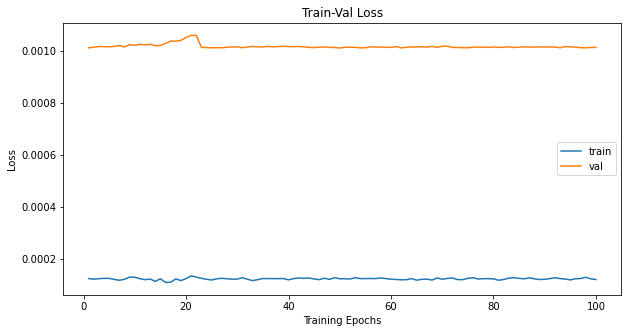

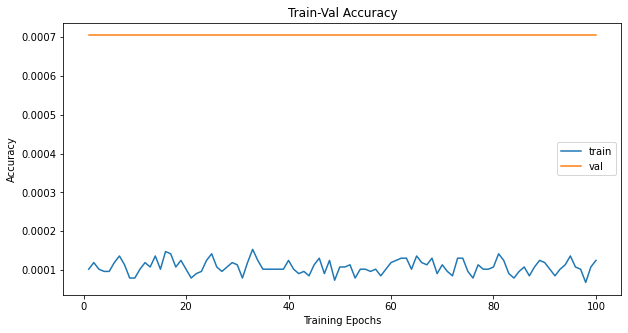

In [58]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [60]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "C:/Users/HeoJiHae/Desktop/허지혜/정보통계학과/파이토치/models/weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/1, current lr=0.0003
Copied best model weights!
train loss: 0.416685, dev loss: 0.379725, accuracy: 83.52
----------
Epoch 1/1, current lr=0.0003
Copied best model weights!
train loss: 0.361030, dev loss: 0.344061, accuracy: 85.56
----------


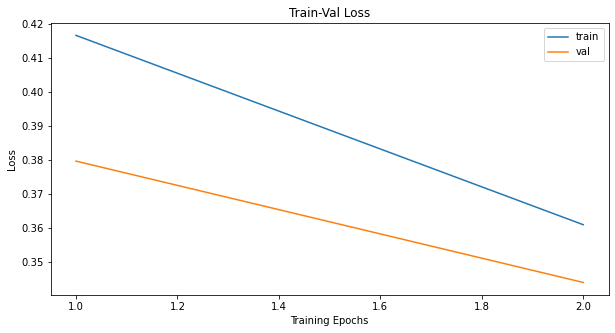

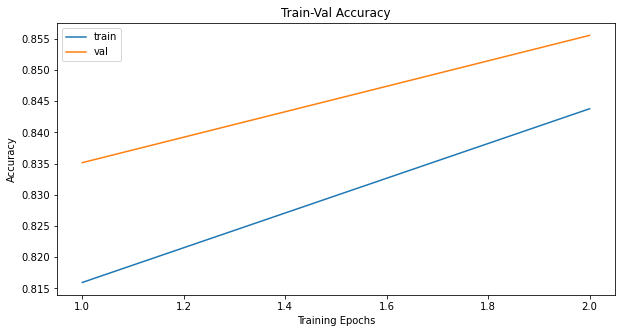

In [61]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

## Deploy : 전개하다.

In [62]:
import torch.nn as nn
import numpy as np
np.random.seed(0)

In [63]:
import torch.nn as nn
import torch.nn.functional as F


def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [64]:
# model parameters
params_model={
 "input_shape": (3,96,96),
 "initial_filters": 8, 
 "num_fc1": 100,
 "dropout_rate": 0.25,
 "num_classes": 2,
 }

# initialize model
cnn_model = Net(params_model)

In [65]:
import torch

path2weights="C:/Users/HeoJiHae/Desktop/허지혜/정보통계학과/파이토치/models/weights.pt"

# load state_dict into model
cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [66]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [67]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device) 

In [68]:
import time 
def deploy_model(model,dataset,device, num_classes=2,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [69]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get a list of images
        self.filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in self.filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename=data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in self.filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [70]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [71]:
data_dir = "./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [72]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [73]:
# deploy model 
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 1.38 ms 
(44005, 2) (44005,)


### Accuracy

In [74]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

(44005,) (44005,)
accuracy: 0.86


In [75]:
### Deploy on CPU

In [76]:
# deploy model on cpu
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cpu: 2.94 ms 
(44005, 2) (44005,)


### Model Inference on Test Data

In [77]:
path2csv="./data/test_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/test_labels.csv'

In [ ]:
data_dir = "./data/"
histo_test = histoCancerDataset(data_dir, data_transformer,data_type="test")
print(len(histo_test))

In [ ]:
y_test_out,_=deploy_model(cnn_model,histo_test, device, sanity_check=False)


y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

In [ ]:
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)


def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))
    
grid_size=4
rnd_inds=np.random.randint(0,len(histo_test),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]

x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)

### Create Submission

In [ ]:
print(y_test_out.shape)
cancer_preds = np.exp(y_test_out[:, 1])
print(cancer_preds.shape)

In [ ]:
# get test id's from the sample_submission.csv 
path2sampleSub = "./data/"+ "sample_submission.csv"

# read sample submission
sample_df = pd.read_csv(path2sampleSub)

# get id column
ids_list = list(sample_df.id)

# convert predictions to to list
pred_list = [p for p in cancer_preds]

# create a dict of id and prediction
pred_dic = dict((key[:-4], value) for (key, value) in zip(histo_test.filenames, pred_list))    


# re-order predictions to match sample submission csv 
pred_list_sub = [pred_dic[id_] for id_ in ids_list]

# create convert to data frame
submission_df = pd.DataFrame({'id':ids_list,'label':pred_list_sub})

# Export to csv
if not os.path.exists("./submissions/"):
    os.makedirs("submissions/")
    print("submission folder created!")
    
path2submission="./submissions/submission.csv"
submission_df.to_csv(path2submission, header=True, index=False)
submission_df.head()